<a href="https://colab.research.google.com/github/kiran1630/brain-tumor-segmentation-u-net-/blob/main/BRAIN_TUMOUR_SEGMENTATION_(U_NET).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lgg-mri-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F181273%2F407317%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241006%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241006T164101Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7c5ecd9e4c511348fa11c1af046bcab57cf9497966546136eaca7498ebea69c3e16b776ecc71d1731dabacd138cd2c2507c28e081f54fb3f725a424ec28799cb22e66a65e546533b797108d0bdbbfeb44fcefeb49a932e06a44aae72977b922379a39e547e13f6daa2c56012ca607e84fb5259ab37aac16b14f7b071dfe9ba72d823553c33d2e11834a4f6bccd7987ba9dbff58aeadea86ea74b8b9579659cc358aa7862637f5479109da396278ebb934a5cab08c5f9416da0e6d1e2a04af7ae48c528b8769dff704531717ae147a00c261c2986fef825f4f11cd0a9c700aaa79cc0fc0a60dc64a1f43dedd502dd686ed6b87fae09b4fac79250737de09957af'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 748584920 bytes downloaded
Downloaded and uncompressed: lgg-mri-segmentation
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ingore the warnings
import warnings
warnings.filterwarnings('ignore')

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D,Input, UpSampling2D, concatenate
from tensorflow.keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
#PreTrained Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
#Image Generator DataAugmentation
from keras.preprocessing import image
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping


# Other libraries
import os
import random

In [4]:
data = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

images = []
masks = []
for filenames in os.walk(data):
    for filename in filenames[2]:
        if 'mask'in filename:
            masks.append(f'{filenames[0]}/{filename}')
            images.append(f'{filenames[0]}/{filename.replace("_mask", "")}')

In [5]:
print('Number of images:',len(images))
print('Number of mask:',len(masks))
df = pd.DataFrame({'image': images, 'mask': masks})

Number of images: 3929
Number of mask: 3929


In [6]:
df.head()
#path of image and mask data

,image,mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [7]:
df.shape

(3929, 2)

In [9]:
import cv2

def load_and_preprocess(images, masks):
    image_data = []
    mask_data = []

    # Load images and masks, convert them to grayscale, and append to lists
    for image_path, mask_path in zip(images, masks):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is not None and mask is not None:
            image_data.append(image)
            mask_data.append(mask)

    # Convert lists to NumPy arrays and normalize pixel values to [0, 1]
    image_data = np.array(image_data) / 255.0
    mask_data = np.array(mask_data) / 255.0

    # Add an extra channel dimension to handle grayscale images
    image_data = np.expand_dims(image_data, axis=-1)
    mask_data = np.expand_dims(mask_data, axis=-1)

    return image_data, mask_data

# Preprocess and return arrays of images and masks
images_array, masks_array = load_and_preprocess(images, masks)

In [11]:
def resize_images(images, masks, target_size=(128, 128)):
    resized_images = []
    resized_masks = []

    # Loop through each image and its corresponding mask
    for image, mask in zip(images, masks):
        # Resize image to target size using INTER_AREA (good for downscaling)
        resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
        # Resize mask to target size using INTER_NEAREST (keeps label boundaries)
        resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

        # Append resized image and mask to their respective lists
        resized_images.append(resized_image)
        resized_masks.append(resized_mask)

    # Convert the list of resized images and masks into NumPy arrays
    return np.array(resized_images), np.array(resized_masks)

# Set target size to 128x128 and resize images and masks
target_size = (128, 128)
resized_images, resized_masks = resize_images(images_array, masks_array, target_size)

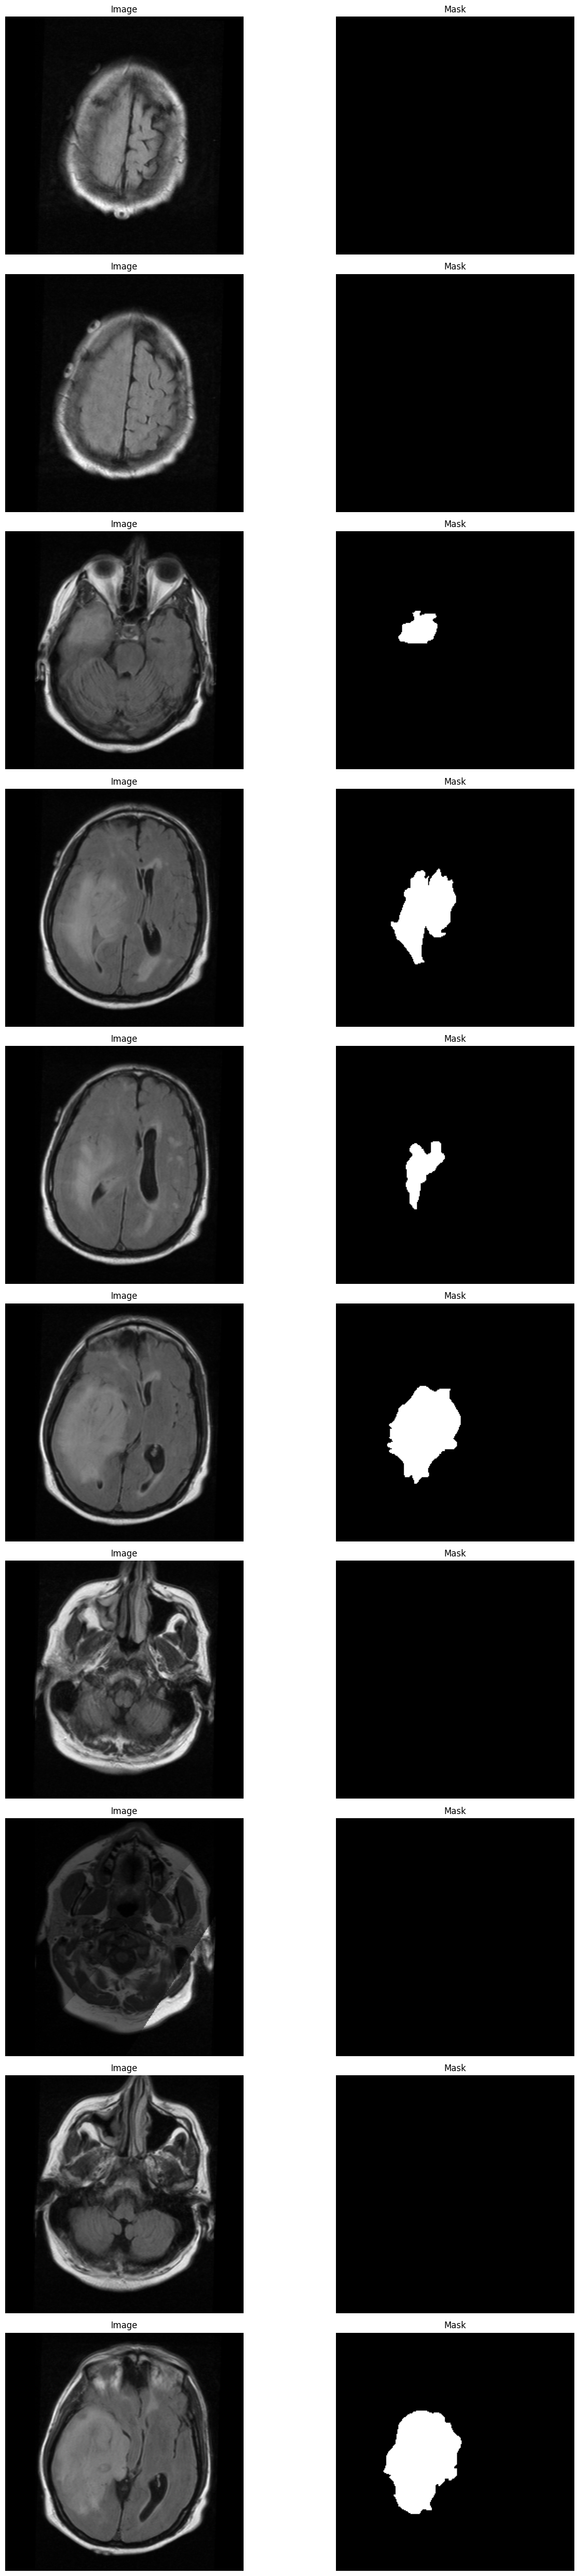

In [12]:
def plot_images(images, masks, num_images=10):
    # Create a figure with a specified size
    plt.figure(figsize=(15, num_images * 5))  # Width of 15 and height based on number of images

    for i in range(num_images):
        # Plot image
        plt.subplot(num_images, 2, 2 * i + 1)  # Arrange subplots in a grid with 2 columns
        plt.title('Image')  # Title for the image subplot
        plt.imshow(images[i].squeeze(), cmap='gray')  # Display image in grayscale
        plt.axis('off')  # Hide axis for a cleaner look

        # Plot mask
        plt.subplot(num_images, 2, 2 * i + 2)  # Position the mask subplot next to the image
        plt.title('Mask')  # Title for the mask subplot
        plt.imshow(masks[i].squeeze(), cmap='gray')  # Display mask in grayscale
        plt.axis('off')  # Hide axis for a cleaner look

    plt.tight_layout()  # Adjust subplots to fit in the figure area
    plt.show()  # Display the figure

# Plot a specified number of images and masks
plot_images(images_array, masks_array, num_images=10)



In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(resized_images, resized_masks, test_size=0.4, random_state=42)

In [14]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [15]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model

def unet_model_functional(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Contracting path
    conv1 = Conv2D(28, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(28, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.3)(pool1)

    conv2 = Conv2D(26, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(26, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.3)(pool2)

    conv3 = Conv2D(26, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(26, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.3)(pool3)

    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.3)(pool4)

    # Bottleneck
    bottleneck = Conv2D(64, (3, 3), activation='relu', padding='same')(pool4)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Conv2D(64, (3, 3), activation='relu', padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Dropout(0.5)(bottleneck)

    # Expansive path
    up5 = UpSampling2D((2, 2))(bottleneck)
    up5 = concatenate([up5, conv4], axis=-1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(0.3)(conv5)

    up6 = UpSampling2D((2, 2))(conv5)
    up6 = concatenate([up6, conv3], axis=-1)
    conv6 = Conv2D(26, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(26, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.3)(conv6)

    up7 = UpSampling2D((2, 2))(conv6)
    up7 = concatenate([up7, conv2], axis=-1)
    conv7 = Conv2D(26, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(26, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.3)(conv7)

    up8 = UpSampling2D((2, 2))(conv7)
    up8 = concatenate([up8, conv1], axis=-1)
    conv8 = Conv2D(28, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(28, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Dropout(0.3)(conv8)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv8)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [16]:
# Create the U-Net model
model = unet_model_functional(input_size=(128, 128, 1))

In [17]:
# Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

# Dice coefficient loss
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# IOU function (Intersection over Union)
def iou(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

In [18]:
# Reshape the labels (y_train and y_val) to have the shape (batch_size, height, width, 1)
y_train = y_train.reshape((-1, 128, 128, 1))
y_val = y_val.reshape((-1, 128, 128, 1))

In [19]:
# Compile the model
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coefficient])

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

In [21]:
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=16,
                    validation_data=(x_val, y_val),callbacks=[early_stopping])

Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 60s 190ms/step - binary_accuracy: 0.7566 - dice_coefficient: 0.0757 - iou: 0.0400 - loss: 0.9243 - val_binary_accuracy: 0.9898 - val_dice_coefficient: 2.0973e-05 - val_iou: 1.0487e-05 - val_loss: 1.0000
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - binary_accuracy: 0.9417 - dice_coefficient: 0.1796 - iou: 0.1012 - loss: 0.8204 - val_binary_accuracy: 0.9898 - val_dice_coefficient: 5.5711e-10 - val_iou: 5.5360e-10 - val_loss: 1.0000
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - binary_accuracy: 0.9757 - dice_coefficient: 0.2930 - iou: 0.1796 - loss: 0.7070 - val_binary_accuracy: 0.9892 - val_dice_coefficient: 0.1007 - val_iou: 0.0607 - val_loss: 0.8975
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - binary_accuracy: 0.9860 - dice_coefficient: 0.3825 - iou: 0.2482 - loss: 0.6175 - val_binary_accuracy: 0.9911 - val_dice_coefficient: 0.4018 - val_iou: 0.2742 - val_loss: 0.6061
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms

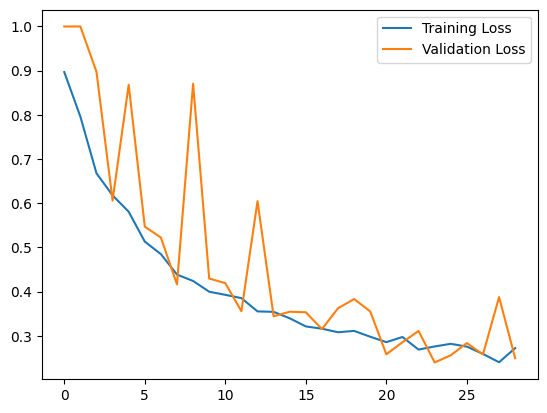

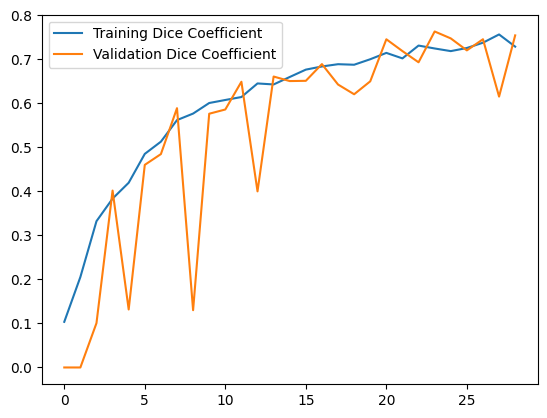

In [22]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot the Dice coefficient or IoU
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


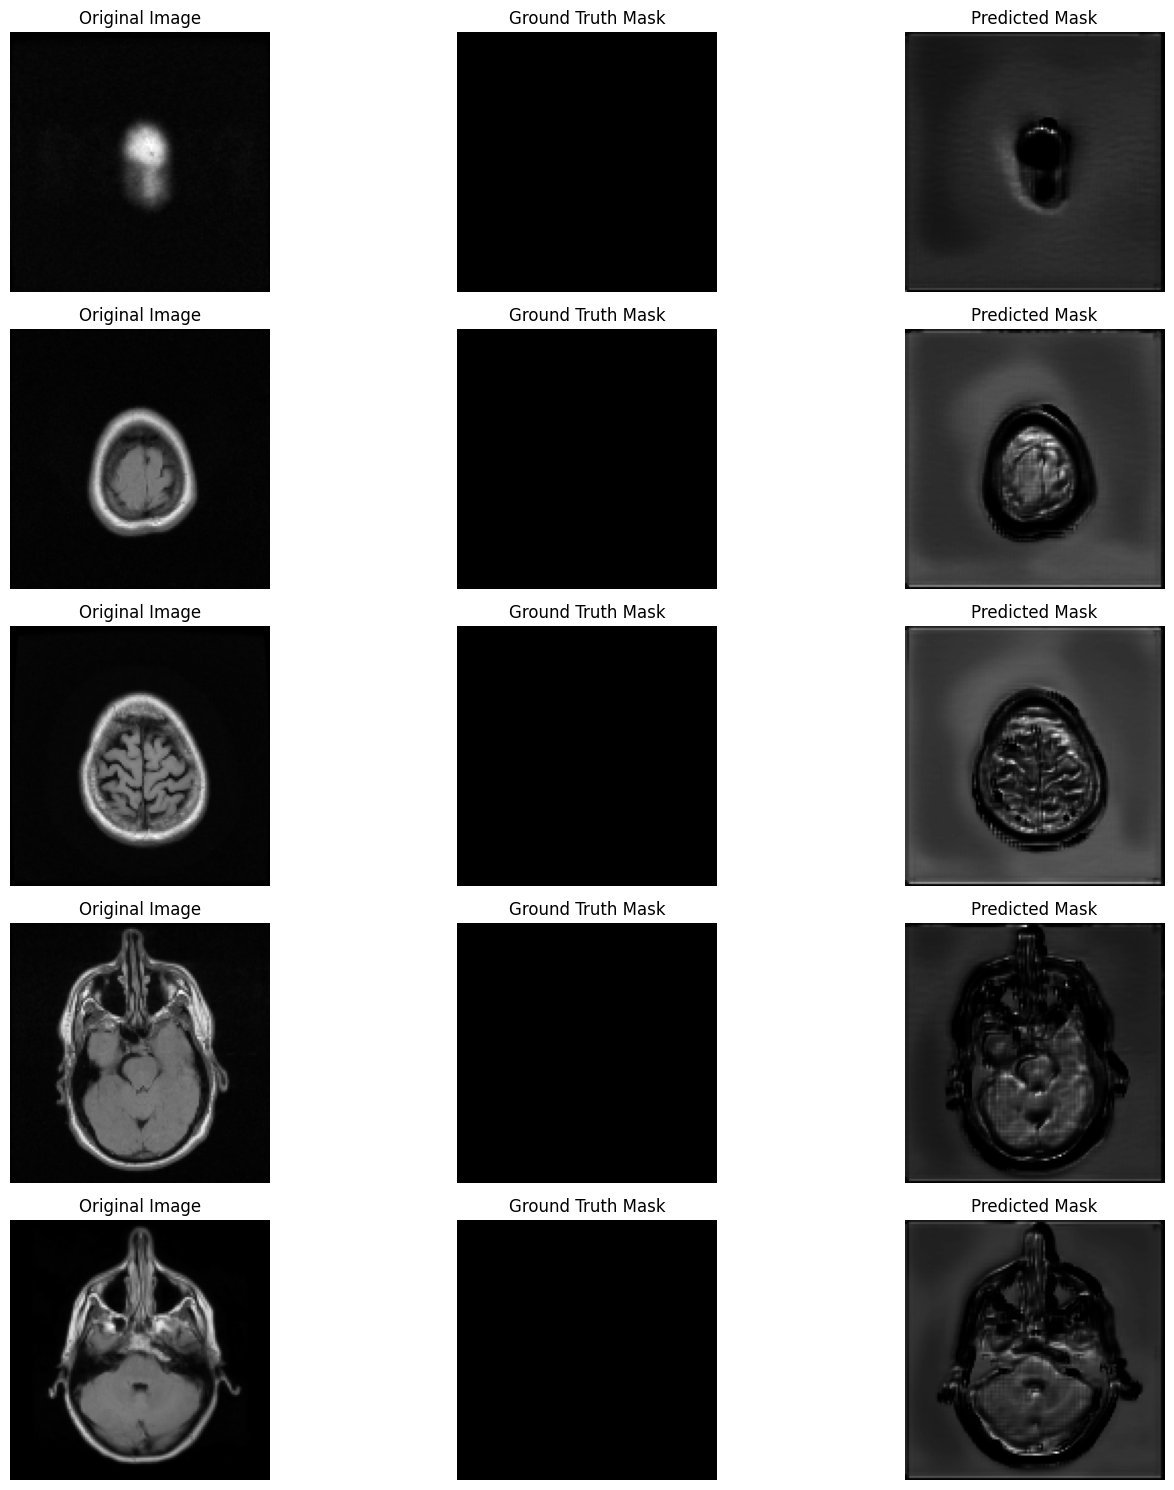

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Function to display original, ground truth, and predicted masks
def display_predictions(images, true_masks, predicted_masks, num_images=5):
    plt.figure(figsize=(15, num_images * 3))

    for i in range(num_images):
        # Original Image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(true_masks[i].reshape(128, 128), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_images, 3, i * 3 + 3)
        # Ensure the predicted mask is in the correct shape for visualization
        pred_mask = predicted_masks[i].reshape(128, 128) if len(predicted_masks.shape) == 4 else predicted_masks[i]
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Select 10 random images from the test set
num_images = 5
indices = np.random.choice(len(x_test), num_images, replace=False)  # Randomly select indices
x_test = x_test[indices]
y_test = y_test[indices]

# Predict masks for the selected images
predicted_masks = model.predict(x_test)

# Display the original images, true masks, and predicted masks
display_predictions(x_test, y_test, predicted_masks, num_images=num_images)